In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fake-and-real-news-dataset


#Step 1: Setup and Data Loading
---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [3]:
import os

# List all files and folders in the dataset path
print(os.listdir(path))


['True.csv', 'Fake.csv']


In [4]:
import pandas as pd

# Load fake and real news data
fake_df = pd.read_csv(os.path.join(path, "Fake.csv"))
real_df = pd.read_csv(os.path.join(path, "True.csv"))

In [5]:
from IPython.display import display

print("Fake News Sample:")
display(fake_df.head())

Fake News Sample:


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
print(" Real News Sample:")
display(real_df.head())

 Real News Sample:


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
# Add labels to the datasets (0 for real, 1 for fake)
fake_df['label'] = 1
real_df['label'] = 0

In [9]:
# Combine the datasets
df = pd.concat([fake_df, real_df], axis=0)

In [10]:
# Display the first few rows
print("Combined Dataset Sample:")
display(df.head())

Combined Dataset Sample:


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [11]:
df.shape

(44898, 5)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [14]:
df.isnull().sum()

,0
title,0
text,0
subject,0
date,0
label,0


In [15]:
df.duplicated().sum()

209

In [16]:
# Drop duplicate rows
df.drop_duplicates(inplace=True)

# Confirm removal
print("Remaining rows after dropping duplicates:", len(df))


Remaining rows after dropping duplicates: 44689


# Step 2: Data Preprocessing
---

In [17]:
# Initialize stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Clean and preprocess text by:
    1. Removing special characters and numbers
    2. Converting to lowercase
    3. Removing stopwords
    4. Stemming words
    """
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)

    # Convert to lowercase
    text = text.lower()

    # Tokenize
    tokens = text.split()

    # Remove stopwords and stem
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

In [19]:
# Apply the preprocessing function to the 'text' column
df['processed_text'] = df['text'].apply(preprocess_text)
# Get the first row's text values
first_text = df.iloc[0]['text']
first_processed = df.iloc[0]['processed_text']

# Print with proper formatting
print("\nOriginal vs Processed Text:")
print("Original:", first_text[:100], "...")
print("Processed:", first_processed[:100], "...")


Original vs Processed Text:
Original: Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had ...
Processed: donald trump wish american happi new year leav instead give shout enemi hater dishonest fake news me ...


In [20]:
# Compare multiple samples
print("\nText Samples Comparison:")
for i in range(3):  # Show first 3 samples
    original = df.iloc[i]['text']
    processed = df.iloc[i]['processed_text']
    print(f"\nSample {i+1}:")
    print("Original:", original[:100], "...")
    print("Processed:", processed[:100], "...")
    print("-" * 50)


Text Samples Comparison:

Sample 1:
Original: Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had ...
Processed: donald trump wish american happi new year leav instead give shout enemi hater dishonest fake news me ...
--------------------------------------------------

Sample 2:
Original: House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the as ...
Processed: hous intellig committe chairman devin nune go bad day assumpt like mani us christoph steeledossi pro ...
--------------------------------------------------

Sample 3:
Original: On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for  ...
Processed: friday reveal former milwauke sheriff david clark consid homeland secur secretari donald trump admin ...
--------------------------------------------------


# Step 3: Exploratory Data Analysis (EDA)
---

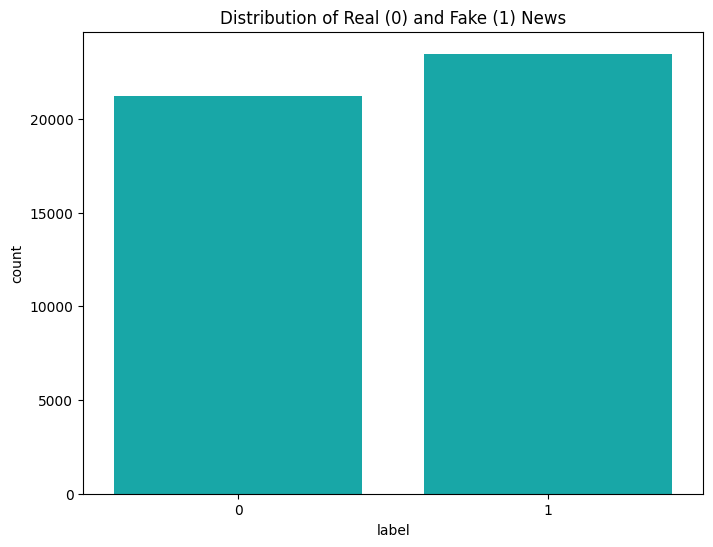

In [21]:
# Plot the distribution of labels
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df, color='c')
plt.title('Distribution of Real (0) and Fake (1) News')
plt.show()

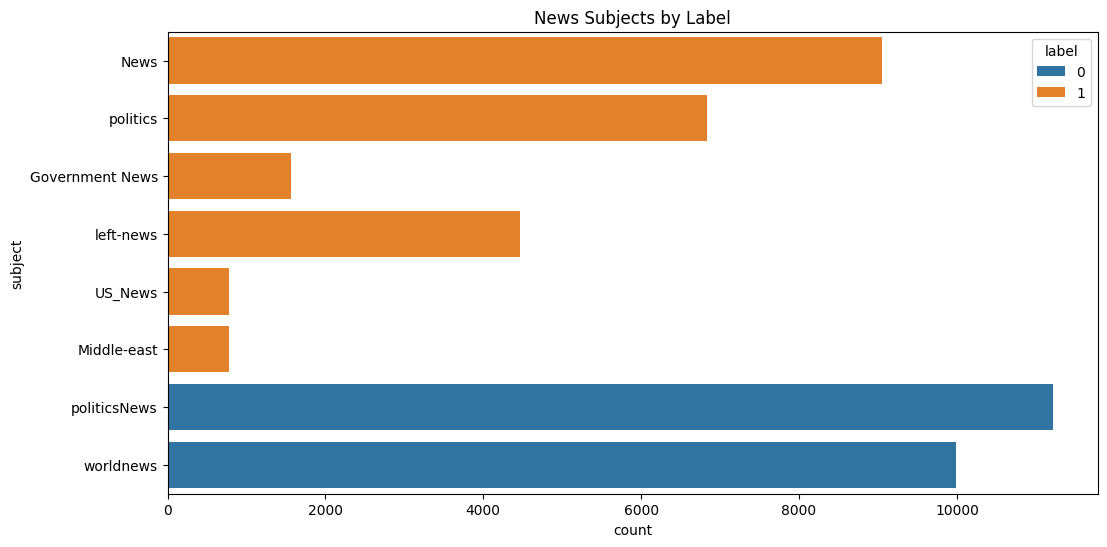

In [22]:
# Plot subject distribution
plt.figure(figsize=(12, 6))
sns.countplot(y='subject', hue='label', data=df)
plt.title('News Subjects by Label')
plt.show()

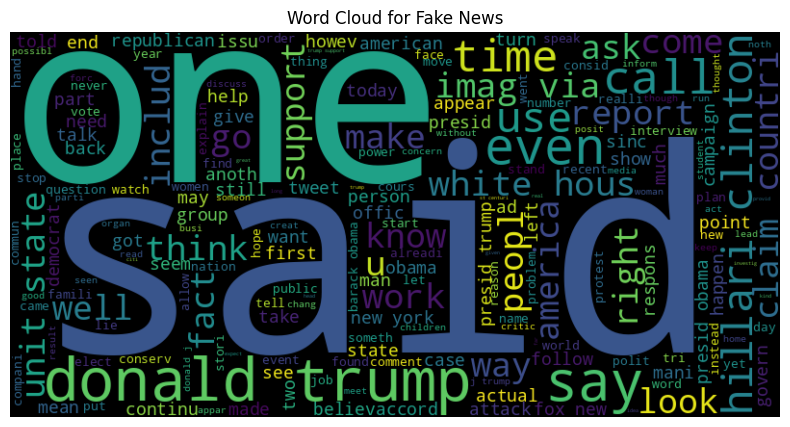

In [23]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_words = ' '.join(df[df['label'] == 1]['processed_text'])
wordcloud = WordCloud(width=800, height=400).generate(fake_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Fake News')
plt.axis('off')
plt.show()

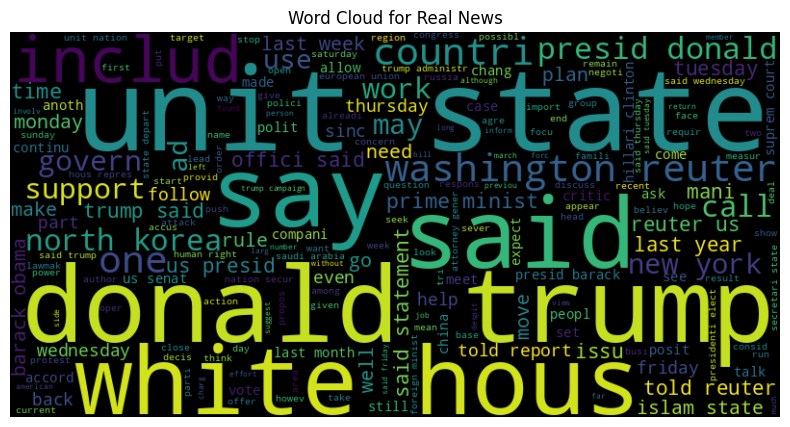

In [24]:
# Word cloud for real news
real_words = ' '.join(df[df['label'] == 0]['processed_text'])
wordcloud = WordCloud(width=800, height=400).generate(real_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Real News')
plt.axis('off')
plt.show()

# Step 4: Feature Extraction with TF-IDF
---

In [25]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

In [26]:
# Fit and transform the processed text
X = tfidf_vectorizer.fit_transform(df['processed_text'])
y = df['label']

In [27]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nDataset Shapes:")
print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)


Dataset Shapes:
Training set: (35751, 5000)
Testing set: (8938, 5000)


# Step 5: Model Training
---

In [28]:
# Initialize PassiveAggressiveClassifier (good for text classification)
model = PassiveAggressiveClassifier(max_iter=1000)
model.fit(X_train, y_train)

PassiveAggressiveClassifier()

In [29]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.2f}")


Model Accuracy: 0.99


In [30]:
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")


Training Accuracy: 1.00
Testing Accuracy: 0.99


In [31]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy: %.2f ± %.2f" % (scores.mean(), scores.std()))


Cross-Validation Accuracy: 0.99 ± 0.00


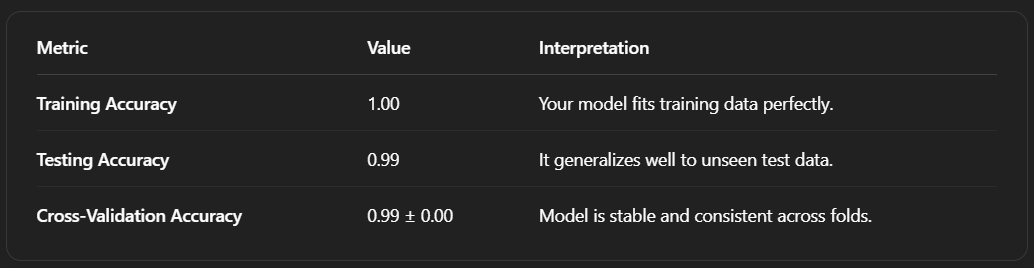

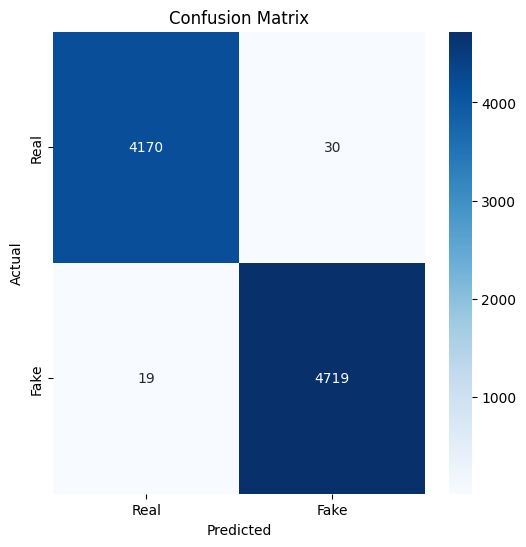

In [32]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


**What it means:**

* 4167 Real articles correctly identified as real.

* 4717 Fake articles correctly identified as fake.

* 33 Real articles mistakenly predicted as fake.

* 21 Fake articles mistakenly predicted as real.



In [33]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4200
           1       0.99      1.00      0.99      4738

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938



**What it means:**

* Precision (0.99): Out of all predicted as real/fake, 99% were correct.

* Recall (0.99/1.00): The model caught nearly all actual real/fake news.

* F1-Score (0.99): Excellent balance between precision & recall.

* Support: Total samples per class.

# Step 6: Testing with Custom Input
---

In [34]:
def predict_news(headline, text):
    """
    Predict whether a news article is fake or real
    """
    # Preprocess the input
    processed_text = preprocess_text(text)

    # Vectorize the text
    text_vector = tfidf_vectorizer.transform([processed_text])

    # Make prediction
    prediction = model.predict(text_vector)

    # Get prediction probability
    proba = model.decision_function(text_vector)
    confidence = 1 / (1 + np.exp(-np.abs(proba)))

    # Return result
    if prediction[0] == 0:
        return f"Real News (Confidence: {confidence[0]:.2f})"
    else:
        return f"Fake News (Confidence: {confidence[0]:.2f})"

In [35]:
# Test with a sample
sample_headline = "Scientists prove that chocolate is good for weight loss"
sample_text = "A new study from Harvard University shows that eating chocolate daily can help you lose up to 10 pounds in a month without exercise."
print("\nPrediction for Sample News:")
print("Headline:", sample_headline)
print(predict_news(sample_headline, sample_text))


Prediction for Sample News:
Headline: Scientists prove that chocolate is good for weight loss
Fake News (Confidence: 0.93)


#  Logging Multiple Predictions
----

In [36]:
from datetime import datetime

# Create a prediction logger function
def log_prediction(headline, text, prediction, confidence, filename="predictions_log.csv"):
    """
    Log predictions to a CSV file with timestamp
    """
    log_entry = {
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'headline': headline,
        'text': text[:200] + "..." if len(text) > 200 else text,  # Store first 200 chars
        'prediction': "Fake" if prediction == 1 else "Real",
        'confidence': confidence
    }

    # Convert to DataFrame and save
    log_df = pd.DataFrame([log_entry])

    try:
        # Append to existing file if it exists
        existing_log = pd.read_csv(filename)
        updated_log = pd.concat([existing_log, log_df], ignore_index=True)
        updated_log.to_csv(filename, index=False)
    except FileNotFoundError:
        # Create new file if it doesn't exist
        log_df.to_csv(filename, index=False)

In [37]:
# Modified predict_news function with logging
def predict_and_log(headline, text):
    processed_text = preprocess_text(text)
    text_vector = tfidf_vectorizer.transform([processed_text])
    prediction = model.predict(text_vector)[0]
    proba = model.decision_function(text_vector)[0]
    confidence = 1 / (1 + np.exp(-np.abs(proba)))

    result = "Fake News" if prediction == 1 else "Real News"
    print(f"\nPrediction: {result} (Confidence: {confidence:.2%})")

    # Log the prediction
    log_prediction(headline, text, prediction, confidence)
    return result, confidence


In [41]:
# Test it
sample_news = [
    ("NASA announces water found on Mars", "NASA scientists have confirmed the presence of water on Mars..."),
    ("Celebrity claims COVID vaccine contains microchips", "A famous actor stated that the vaccines contain tracking devices...")
]
for headline, text in sample_news:
    predict_and_log(headline, text)

print("\nPredictions logged to predictions_log.csv")




Prediction: Fake News (Confidence: 83.66%)

Prediction: Fake News (Confidence: 92.74%)

Predictions logged to predictions_log.csv


#  Building a Web Interface with Streamlit
---

In [40]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.3 MB/s eta 0:00:00


In [42]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib
from datetime import datetime
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk

In [43]:
import joblib

# Save the trained model
joblib.dump(model, 'fake_news_detector.pkl')


['fake_news_detector.pkl']

In [44]:
# Save the TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [62]:
# Save the files
with open('app.py', 'w') as f:
    f.write('''
import streamlit as st
import pandas as pd
import joblib
from datetime import datetime
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
import numpy as np
import base64

# Configure page settings - MUST BE FIRST STREAMLIT COMMAND
st.set_page_config(
    page_title="Fake News Detector AI",
    page_icon="📰",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Custom CSS styling
st.markdown(\"""
<style>
    /* Main styles */
    .header-style {
        font-size: 36px;
        font-weight: bold;
        color:  #f8f9fa;
        margin-bottom: 20px;
    }
    .subheader-style {
        font-size: 18px;
        color: #f5eded;
        margin-bottom: 30px;
    }
    .input-header {
        font-size: 20px;
        font-weight: bold;
        color: #f8f9fa;
        margin-top: 20px;
    }
    .result-box {
        border-radius: 10px;
        padding: 20px;
        margin: 20px 0;
        box-shadow: 0 4px 6px rgba(0,0,0,0.1);
    }
    .real-news {
        background-color: #b4edb9;
        border-left: 5px solid #2e7d32;
    }
    .fake-news {
        background-color: #e87687;
        border-left: 5px solid #c62828;
    }
    .indicator-item {
        margin: 10px 0;
        padding: 8px;
        border-radius: 5px;
        background-color: #f5f5f5;
    }
    .positive-indicator {
        background-color: #1b7051;
    }
    .negative-indicator {
        background-color: #9e1c1c;
    }
    .history-table {
        margin-top: 20px;
    }
    .indicator-title {
        font-weight: bold;
        color: #1a1a1a;
        margin-bottom: 8px;
    }
    .indicator-content {
        color: #333333;
        padding-left: 15px;
    }
    /* Text colors */
    .dark-text {
        color: #1a1a1a !important;
    }
    .medium-text {
        color: #333333 !important;
    }
    /* Sidebar improvements */
    .sidebar .sidebar-content {
        background-color: #f8f9fa;
    }
    .sidebar-title {
        color: #f8f9fa;
    }
    /* Button styling */
    .stButton>button {
        background-color: #4CAF50;
        color: white;
        border-radius: 8px;
        padding: 10px 24px;
        font-weight: bold;
        border: none;
        transition: all 0.3s;
    }
    .stButton>button:hover {
        background-color: #388e3c;
        transform: translateY(-2px);
    }
    /* Input field styling */
    .stTextInput>div>div>input, .stTextArea>div>div>textarea {
        border-radius: 8px;
        padding: 10px;
    }
</style>
\""", unsafe_allow_html=True)

# Download NLTK data
nltk.download('stopwords')

# Initialize stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Load model and vectorizer
try:
    model = joblib.load('fake_news_detector.pkl')
    tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
except:
    st.error("Model files not found! Please upload 'fake_news_detector.pkl' and 'tfidf_vectorizer.pkl'")
    st.stop()

# Preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# ========== SIDEBAR ==========
with st.sidebar:
    st.image("https://cdn-icons-png.flaticon.com/512/2491/2491907.png", width=100)
    st.markdown("<div class='header-style'>About</div>", unsafe_allow_html=True)
    st.markdown(\"""
    This **Fake News Detector AI** uses advanced machine learning to analyze news articles
    and predict their authenticity with **99% accuracy**.

    ### How it works:
    1. Enter a news headline and article text
    2. Click "Analyze Article"
    3. View detailed results

    ### Model details:
    - **Algorithm:** Passive Aggressive Classifier
    - **Features:** TF-IDF text vectorization
    - **Training data:** 40,000+ real and fake news articles

    *Note: Always verify information from multiple sources.*
    \""")

    st.markdown("---")
    st.markdown(\"""
    <div style="font-size:14px; color:#7f8c8d;">
    Developed by AI Research Team<br>
    Version 2.0 • April 2025
    </div>
    \""", unsafe_allow_html=True)

# ========== MAIN CONTENT ==========
st.markdown("<div class='header-style'>📰 Fake News Detector AI</div>", unsafe_allow_html=True)
st.markdown("<div class='subheader-style'>Verify the authenticity of news articles using artificial intelligence</div>", unsafe_allow_html=True)

# Input section
with st.container():
    st.markdown("<div class='input-header'>Enter Article Details</div>", unsafe_allow_html=True)
    col1, col2 = st.columns([1, 1])

    with col1:
        headline = st.text_input(
            "**Headline**",
            placeholder="Enter the news headline...",
            key="headline"
        )

    with col2:
        article_text = st.text_area(
            "**Full Article Text**",
            placeholder="Paste the full article text here...",
            height=200,
            key="article_text"
        )

# Analysis button
analyze_button = st.button(
    "🔍 Analyze Article",
    type="primary",
    help="Click to analyze the article's authenticity"
)

# Results section
if analyze_button and headline and article_text:
    try:
        # Process and predict
        processed_text = preprocess_text(article_text)
        text_vector = tfidf_vectorizer.transform([processed_text])

        # Get prediction
        prediction = model.predict(text_vector)[0]
        proba = model.decision_function(text_vector)[0]
        confidence = 1 / (1 + np.exp(-np.abs(proba)))

        # Display results in a styled container
        result_class = "fake-news" if prediction == 1 else "real-news"

        with st.container():
            st.markdown(f"<div class='result-box {result_class}'>", unsafe_allow_html=True)

            if prediction == 1:
                st.markdown(\"""
                <div style='display:flex; align-items:center;'>
                    <h2 style='color:#c62828; margin-right:15px;'>⚠️ Fake News Detected</h2>
                    <div style='margin-left:auto; font-size:24px; font-weight:bold; color:#c62828;'>
                        {:.1f}% Confidence
                    </div>
                </div>
                \""".format(confidence*100), unsafe_allow_html=True)
            else:
                st.markdown(\"""
                <div style='display:flex; align-items:center;'>
                    <h2 style='color:#055c3c; margin-right:15px;'>✅ Authentic News</h2>
                    <div style='margin-left:auto; font-size:24px; font-weight:bold; color:#055c3c;'>
                        {:.1f}% Confidence
                    </div>
                </div>
                \""".format(confidence*100), unsafe_allow_html=True)

            # Confidence meter
            st.progress(float(confidence))

            # Key indicators
            st.markdown("<h3 style='margin-top:20px; color:#f8f9fa;'>Key Indicators</h3>", unsafe_allow_html=True)

            if prediction == 1:
                st.markdown(\"""
                <div class='indicator-item negative-indicator'>
                    <b>Emotional Language:</b> Contains excessive emotional or sensational wording
                </div>
                <div class='indicator-item negative-indicator'>
                    <b>Source Quality:</b> Lacks credible sources or references
                </div>
                <div class='indicator-item negative-indicator'>
                    <b>Verifiability:</b> Makes claims that are difficult to verify
                </div>
                <div class='indicator-item negative-indicator'>
                    <b>Balance:</b> Presents one-sided arguments without counterpoints
                </div>
                \""", unsafe_allow_html=True)
            else:
                st.markdown(\"""
                <div class='indicator-item positive-indicator'>
                    <b>Neutral Tone:</b> Uses factual, objective language
                </div>
                <div class='indicator-item positive-indicator'>
                    <b>Credible Sources:</b> Cites authoritative references
                </div>
                <div class='indicator-item positive-indicator'>
                    <b>Verifiable Facts:</b> Contains checkable information
                </div>
                <div class='indicator-item positive-indicator'>
                    <b>Balanced Reporting:</b> Presents multiple perspectives
                </div>
                \""", unsafe_allow_html=True)

            st.markdown("</div>", unsafe_allow_html=True)

            # Log the prediction
            log_entry = pd.DataFrame([{
                'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                'headline': headline,
                'prediction': "Fake" if prediction == 1 else "Real",
                'confidence': f"{confidence:.2%}"
            }])

            try:
                existing_log = pd.read_csv("web_predictions.csv")
                updated_log = pd.concat([existing_log, log_entry])
            except FileNotFoundError:
                updated_log = log_entry

            updated_log.to_csv("web_predictions.csv", index=False)

    except Exception as e:
        st.error(f"An error occurred during analysis: {str(e)}")
elif analyze_button and (not headline or not article_text):
    st.warning("Please enter both a headline and article text to analyze")

# Prediction history section
st.markdown("---")
with st.expander("📜 View Analysis History", expanded=False):
    try:
        history = pd.read_csv("web_predictions.csv")
        history = history.sort_values('timestamp', ascending=False)

        if not history.empty:
            # Format confidence as percentage
            history['Confidence'] = history['confidence'].apply(lambda x: f"{float(x.strip('%')):.1f}%")

            # Display styled dataframe
            st.dataframe(
                history[['timestamp', 'headline', 'prediction', 'Confidence']],
                column_config={
                    "timestamp": "Timestamp",
                    "headline": "Headline",
                    "prediction": st.column_config.SelectboxColumn(
                        "Verdict",
                        options=["Real", "Fake"],
                        required=True
                    ),
                    "Confidence": "Confidence"
                },
                hide_index=True,
                use_container_width=True
            )

            # Add download button
            csv = history.to_csv(index=False).encode('utf-8')
            st.download_button(
                label="📥 Download Full History",
                data=csv,
                file_name="fake_news_detection_history.csv",
                mime="text/csv"
            )
        else:
            st.info("No analysis history yet. Analyze some articles to build history.")
    except FileNotFoundError:
        st.info("No analysis history yet. Analyze some articles to build history.")

# Footer
st.markdown("---")
st.markdown(\"""
<div style="text-align:center; color:#7f8c8d; font-size:14px; margin-top:50px;">
    For educational purposes only • Not a substitute for professional fact-checking
</div>
\""", unsafe_allow_html=True)
''')

In [58]:
!pip install streamlit pyngrok


In [59]:
!npm install -g localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇
changed 22 packages in 2s
⠇
⠇3 packages are looking for funding
⠇  run `npm fund` for details
⠇

In [63]:
!wget -q -O - ipv4.icanhazip.com

34.169.250.95


In [64]:
! streamlit run /content/app.py & npx localtunnel --port 8501



⠙⠹⠸⠼
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.2:8501
  External URL: http://34.169.250.95:8501

⠴⠦your url is: https://five-beds-walk.loca.lt
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
  Stopping...
^C
